# Plotting sea ice 

In [58]:
import cosima_cookbook as cc
from dask.distributed import Client

import xarray as xr
import matplotlib.pyplot as plt
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.path as mpath
import numpy as np
%matplotlib inline

# Stop annoying warnings coming out of xarray.
import warnings
warnings.filterwarnings('ignore')

In [42]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/41091/status,
Dashboard: /proxy/41091/status,Workers: 7
Total threads: 28,Total memory: 128.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38417,Workers: 7
Dashboard: /proxy/41091/status,Total threads: 28
Started: Just now,Total memory: 128.00 GiB
Comm: tcp://127.0.0.1:44359,Total threads: 4
Dashboard: /proxy/45867/status,Memory: 18.29 GiB
Nanny: tcp://127.0.0.1:38495,


In [43]:
session_CM2  = cc.database.create_session('/g/data/p73/archive/non-CMIP/ACCESS-CM2/CM2.db')
expt_CM2_025 = 'cj877'
expt_CM2_1   = 'bz687'

In [44]:
# OM2 database
session_OM2  = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
expt_OM2_025 = '025deg_jra55_ryf9091_gadi'
expt_OM2_1   = '1deg_jra55_ryf9091_gadi'

If you get a 'read-only database' warning, it is because the database has not finished building. 

In [45]:
path_to_data = '/g/data/x77/wgh581/Post_Process/ACCESS_CM2_025/'
fig_path = '/g/data/x77/wgh581/Figures/Figures_ACCESS_CM2/'

In [46]:
# Plotting info
ft_size = 16
plt.rcParams.update({'font.size': ft_size})

### Ice area

In [ ]:
hi_m = cc.querying.getvar(control, 'hi', session_CM2, frequency='1 monthly', start_time='0001-01-01', end_time='0001-12-31')

In [ ]:
aice_m = cc.querying.getvar(control, 'aice', session_CM2, frequency='1 monthly', start_time='0001-01-01', end_time='0001-12-31')

In [ ]:
area_t = cc.querying.getvar(control, 'area_t',session_CM2,n=1)

2022-08-31 18:47:05,192 - distributed.nanny - WARNING - Restarting worker
2022-08-31 18:47:05,221 - distributed.nanny - WARNING - Restarting worker
2022-08-31 18:47:05,240 - distributed.nanny - WARNING - Restarting worker
2022-08-31 18:47:05,242 - distributed.nanny - WARNING - Restarting worker
2022-08-31 18:47:05,256 - distributed.nanny - WARNING - Restarting worker
2022-08-31 18:47:05,290 - distributed.nanny - WARNING - Restarting worker
2022-08-31 18:47:08,740 - distributed.nanny - WARNING - Restarting worker


In [7]:
def get_aice(expt, session, start_time, end_time, frequency='1 monthly'):
    
    var = cc.querying.getvar(expt, 'aice', session, frequency=frequency, start_time=start_time, end_time=end_time)
    area_t = cc.querying.getvar(expt, 'area_t', session, n=1)
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    #var = var[2::12,:,:]
    
    area = var*area_t
    area_zonalsum = area.sum('xt_ocean')
    NH_area = area_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean')
    #SH_area = area_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean')
    
    return NH_area#, SH_area

In [13]:
%%time
#NH_area, SH_area = get_aice(control, session_CM2, '0001-01-01', '0100-12-31')
NH_area= get_aice(control, session_CM2, '0300-01-01', '0399-12-31')

CPU times: user 4min 15s, sys: 38 s, total: 4min 53s
Wall time: 15min 8s


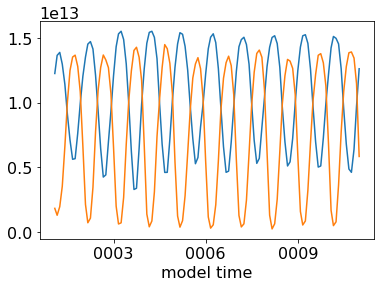

In [68]:
NH_area.plot()
SH_area.plot()

In [14]:
NH_area.to_netcdf(path_to_data + 'NH_sea_ice_area_300_400.nc')
#SH_area.to_netcdf(path_to_data + 'SH_sea_ice_area_0_100.nc')

Load, concatenate and save individual files

In [15]:
data1 = xr.open_dataarray(path_to_data + 'SH_sea_ice_area_0_100.nc')
data2 = xr.open_dataarray(path_to_data + 'SH_sea_ice_area_100_200.nc')
data3 = xr.open_dataarray(path_to_data + 'SH_sea_ice_area_200_300.nc')
data4 = xr.open_dataarray(path_to_data + 'SH_sea_ice_area_300_400.nc')
data5 = xr.open_dataarray(path_to_data + 'SH_sea_ice_area_400_500.nc')

In [16]:
SH_sea_ice_area = xr.concat([data1, data2, data3, data4, data5], dim="time")

In [18]:
data1 = xr.open_dataarray(path_to_data + 'NH_sea_ice_area_0_100.nc')
data2 = xr.open_dataarray(path_to_data + 'NH_sea_ice_area_100_200.nc')
data3 = xr.open_dataarray(path_to_data + 'NH_sea_ice_area_200_300.nc')
data4 = xr.open_dataarray(path_to_data + 'NH_sea_ice_area_300_400.nc')
data5 = xr.open_dataarray(path_to_data + 'NH_sea_ice_area_400_500.nc')

In [19]:
NH_sea_ice_area = xr.concat([data1, data2, data3, data4, data5], dim="time")

In [46]:
# Saving 
SH_sea_ice_area.to_netcdf(path_to_data + 'SH_sea_icea_area.nc')
NH_sea_ice_area.to_netcdf(path_to_data + 'NH_sea_icea_area.nc')

Plotting

In [55]:
test = NH_sea_ice_area[({"time": NH_sea_ice_area.time.dt.month == 6})]

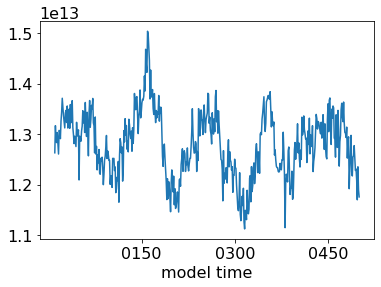

In [57]:
test.plot()

Load in previsously calcualted data

In [14]:
NH_sea_ice_area = xr.open_dataarray(path_to_data + 'NH_sea_icea_area.nc')
SH_sea_ice_area = xr.open_dataarray(path_to_data + 'SH_sea_icea_area.nc')

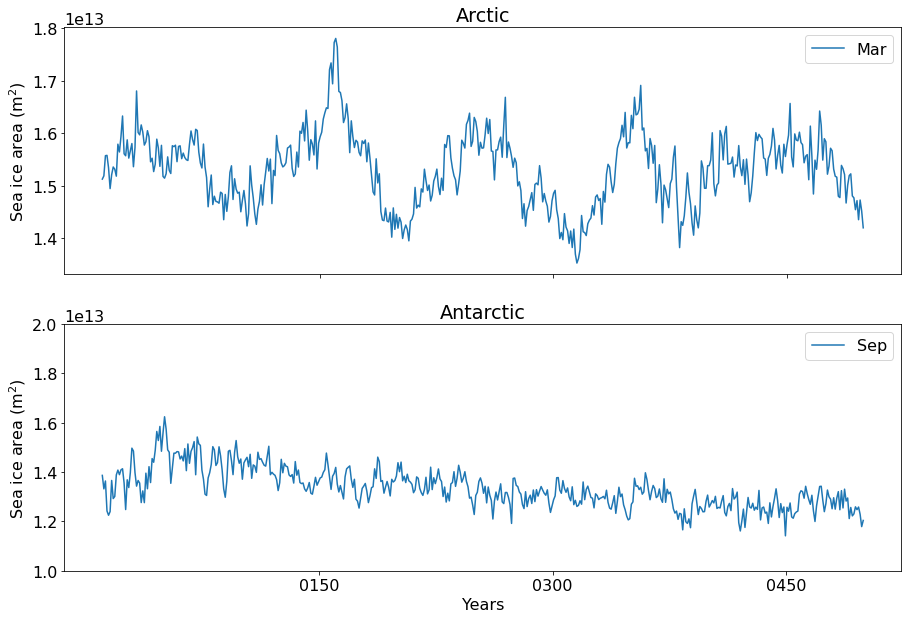

In [44]:
fig = plt.figure(figsize=(15,10))

month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig.add_subplot(211)
for ii in range(1):
    jj = 3 + ii
    NH_sea_ice_area[({"time": NH_sea_ice_area.time.dt.month == jj})].plot(label=month[jj-1])
plt.legend()
#plt.ylim(1e13, 2e13)
plt.tick_params(labelbottom=False)
plt.xlabel('')
plt.ylabel('Sea ice area (m$^{2}$)')
plt.title('Arctic')

fig.add_subplot(212)
for ii in range(1):
    jj = 9 + ii
    #SH_se_ice_area[jj::12].plot(label=month[jj])
    SH_sea_ice_area[({"time": SH_sea_ice_area.time.dt.month == jj})].plot(label=month[jj-1])
plt.legend()
plt.ylim(1e13, 2e13)
plt.ylabel('Sea ice area (m$^{2}$)')
plt.xlabel('Years')
plt.title('Antarctic')

# Finished
save_flag = 1
if save_flag == 1:
    fig_name = 'Fig_SIA_A_AA_timeseries.png'
    plt.savefig(fig_path + fig_name);

#### Add upper ohc to time series

In [15]:
uohc_CM2_025 = xr.open_dataarray(path_to_data + 'uohc_annual.nc')
area_CM2_025 = cc.querying.getvar(expt_CM2_025, 'area_t', session_CM2, n=1)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [16]:
# Mask
area_CM2_025 = uohc_CM2_025[0,:,:]/uohc_CM2_025[0,:,:]*area_CM2_025

In [17]:
lat_slice = slice(40,65)
lon_slice = slice(-99,25)
var = uohc_CM2_025.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice) * area_CM2_025.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
uohc_CM2_025_NA = var.sum('xt_ocean').sum('yt_ocean').compute()

In [18]:
uohc_CM2_025_NA_norm = uohc_CM2_025_NA / area_CM2_025.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sum('xt_ocean').sum('yt_ocean')

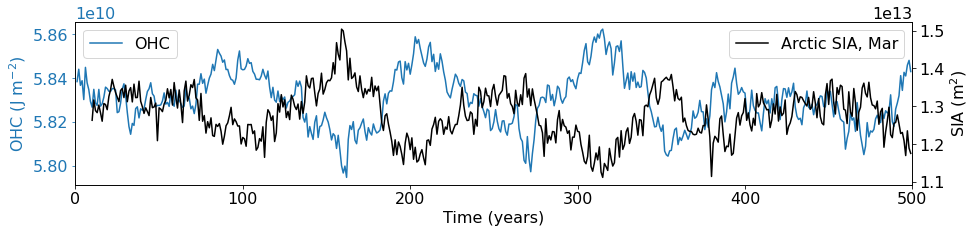

In [45]:
fig, ax1 = plt.subplots(figsize=(15,3))

uohc_CM2_025_NA_norm.plot(label='OHC')

ax2 = ax1.twinx()
sic_year = NH_sea_ice_area[({"time": NH_sea_ice_area.time.dt.month == 6})].time.dt.year
sic_data = NH_sea_ice_area[({"time": NH_sea_ice_area.time.dt.month == 6})]
plt.plot(sic_year, sic_data, color='k', label='Arctic SIA, Mar')
#NH_sea_ice_area[({"time": NH_sea_ice_area.time.dt.month == 6})].plot(color='k', label='Arctic SIC')

ax1.legend(loc=2)
ax2.legend(loc=1)
ax1.set_xlabel('Time (years)')
ax1.set_title('')
ax2.set_title('')
ax1.set_ylabel('OHC (J m$^{-2}$)', color='C0')
ax2.set_ylabel('SIA (m$^2$)')
#ax1.yaxis.label.set_color('C0')
ax1.tick_params(axis='y', colors='C0')
plt.xlim(0, 500)

# Finished
save_flag = 1
if save_flag == 1:
    fig_name = 'Fig_SIA_OHC_timeseries.png'
    plt.savefig(fig_path + fig_name);

FFT on both time series

In [46]:
def get_spectrum(data):
    sampling_rate = 1
    fourier_transform = np.fft.rfft(data)
    abs_fourier_transform = np.abs(fourier_transform)
    power_spectrum = np.square(abs_fourier_transform)
    frequency = np.linspace(0, sampling_rate/2, len(power_spectrum))
    
    return frequency, power_spectrum

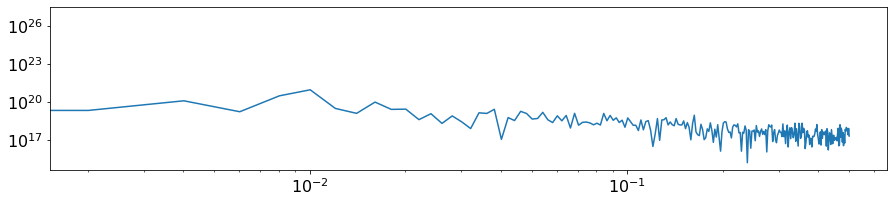

In [48]:
# OHC North Atlantic

freq, ps = get_spectrum(uohc_CM2_025_NA_norm)

fig = plt.figure(figsize=(15,3))

plt.loglog(freq, ps)
# maxima = [5, 112, 196, 325, 382]
# for ii in maxima:
#     plt.scatter(freq[ii], ps[ii], color='r')
#     print(int(np.round(1/freq[ii])), 'years')

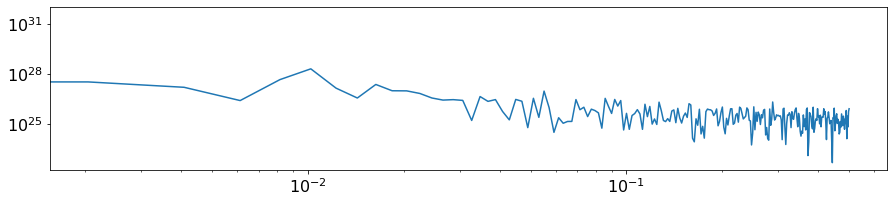

In [49]:
# Sea ice area, Arctic

freq, ps = get_spectrum(NH_sea_ice_area[({"time": NH_sea_ice_area.time.dt.month == 6})])

fig = plt.figure(figsize=(15,3))

plt.loglog(freq, ps)

### Sea ice concentration maps

In [47]:
area_t = cc.querying.getvar(expt_CM2_025, 'area_t', session_CM2, n=1)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [48]:
aice_m = cc.querying.getvar(expt_CM2_025, 'aice', session_CM2, frequency='1 monthly', start_time='0001-01-01', end_time='0001-12-31')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, cal

In [49]:
aice_m.coords['ni'] = area_t['xt_ocean'].values
aice_m.coords['nj'] = area_t['yt_ocean'].values
aice_m = aice_m.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

In [50]:
geolon_t = cc.querying.getvar(expt_CM2_025, 'geolon_t', session_CM2, n=-1)
geolat_t = cc.querying.getvar(expt_CM2_025, 'geolat_t', session_CM2, n=-1)

aice_m = aice_m.assign_coords({'geolon_t': geolon_t, 'geolat_t': geolat_t})

In [54]:
aice_m

<xarray.DataArray 'aice' (time: 12, yt_ocean: 1080, xt_ocean: 1440)>
dask.array<concatenate, shape=(12, 1080, 1440), dtype=float32, chunksize=(1, 540, 720), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0001-02-01 00:00:00 ... 0002-01-01 00:00:00
    TLON      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(540, 720), meta=np.ndarray>
    TLAT      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(540, 720), meta=np.ndarray>
    ULON      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(540, 720), meta=np.ndarray>
    ULAT      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(540, 720), meta=np.ndarray>
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(540, 720), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(540, 720), meta=np.ndarray>
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged
    time_bounds:    <xarray.DataArray 'time_bounds' (time: 12, d2: 2)>\ndask....
    ncfiles:        ['/g/data/p73/archive/non-CMIP/ACCESS-CM2/cj877/history/i...
    contact:        Martin Dix
    email:          martin.dix@csiro.au
    created:        2021-11-30
    description:    ACCESS-CM2 with n96 atmosphere coupled to COSIMA OM2 0.25...
    url:            https://code.metoffice.gov.uk/svn/roses-u/c/j/8/7/7/trunk

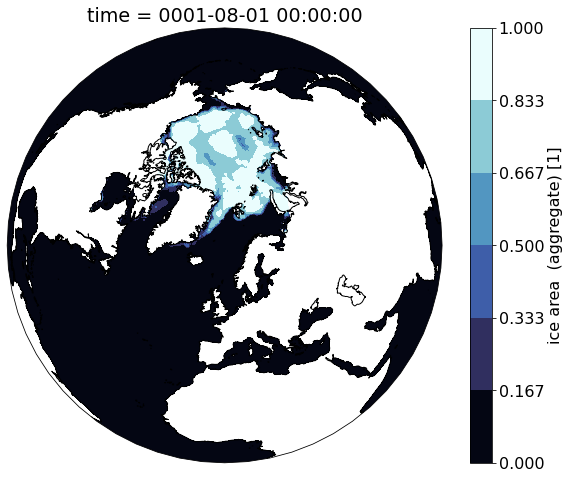

In [56]:
plt.figure(figsize=(10, 8))

ax = plt.axes(projection=ccrs.Orthographic(central_latitude=70, central_longitude=0))

aice_m[6,:,:].plot.contourf(x='geolon_t', y='geolat_t', transform=ccrs.PlateCarree(), vmin=0, vmax=1, cmap=cm.cm.ice) #  

ax.coastlines(resolution='50m');

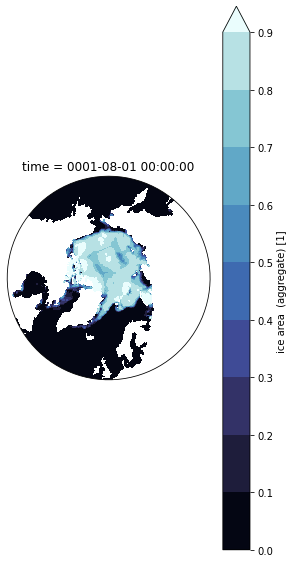

In [84]:
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(1, 2, 2, projection=ccrs.NorthPolarStereo())
#  class cartopy.crs.NorthPolarStereo(central_longitude=0.0, globe=None)[source]

ax.set_extent([-280, 80, 50, 90], crs=ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
aice_m.sel(yt_ocean=slice(50,90))[6,:,:].plot.contourf(x='geolon_t', y='geolat_t', levels=np.arange(0, 1, 0.1), transform=ccrs.PlateCarree(), vmin=0, vmax=1, cmap=cm.cm.ice)
# lat_lims = [70,90]
# polarCentral_set_latlim(lat_lims, ax)

In [85]:
fig_path

'/g/data/x77/wgh581/Figures/Figures_ACCESS_CM2/'

### Ice volume

In [75]:
from cosima_cookbook import explore
dbx = explore.DatabaseExplorer(session=session_CM2)

In [76]:
dbx

DatabaseExplorer(children=(HTML(value='<style>.header p{ line-height: 1.4; margin-bottom: 10px }</style>\n    …